In [1]:
# Sutton's book Chapter 5: Blackjack with Monte Carlo Exploring Start
import random
import numpy as np
from scipy.stats import beta
import matplotlib.pyplot as plt

DECK_OF_CARDS = [1,2,3,4,5,6,7,8,9,10,10,10,10] * 4 #J, Q, K count as 10.
DEALDER_STICK_THRESHOLD = 17 # same as Sutton's and Vega's rule: https://www.youtube.com/watch?v=SWdPf21v5Ak

def sum_hand(hand):
    min_s = sum(hand)
    max_s = sum(hand)
    if 1 in hand:
        max_s = min_s  + 10
    if max_s <= 21 and max_s > min_s:
        ## Has a usable ACE.
        return (max_s, 1)
    else:
        return (min_s, 0)
    
def busted(hand):
    (s, _) = sum_hand(hand)
    return s > 21    
    
def convert_cards_to_state(my_cards, dealer_card):
    (s, usable_ace) = sum_hand(my_cards)
    # state is 0-based, for easy indexing with ndarray.
    return (s-1, dealer_card-1, usable_ace)

In [2]:
class BasePlayer(object):
    # Return 1 if hit, 0 if stick.
    def action(self, cards, rival_card):
        raise NotImplementedError("action() is not implemented.")

class Dealer(BasePlayer):
    def __init__(self):
        self.stick_threshold = DEALDER_STICK_THRESHOLD
    def action(self, cards):
        (s, _) = sum_hand(cards) #s>=1 
        return int(self.stick_threshold > s) #stick for 17 or greater, same as Sutton's 

In [3]:
class Policy(object):
    def __init__(self):
        # stats is a 5D tensor. 
        # The first 3 dimensions describe state. The 4th dimension describes
        # action (0 for stick, 1 for hit). The 5th dimension describes the
        # reward: {-1, 0, 1}.
        # self.states[i][j][k][a][r] saves counts of how many times we have
        # reward `r` when we take action `a` for state s = (i, j, k) (s is 0-based).
        self.stats = np.zeros((21, 10, 2, 2, 3), dtype='int64') # Init to 1 instead of 0 to smooth out.
        # q is a 4D tensor that represents q(s, a).
        self.q = np.zeros((21, 10, 2, 2), dtype='float64')
        # pi is a 4D tensor that represents pi(a|s), last dimension is the action
        self.pi = np.zeros((21, 10, 2, 2), dtype='float64')
        #pi[:,:,:,1] is the probability of hit while pi[:,:,:,0] is the probability of stick
        self.pi[0:11,:,:,:] = [0., 1.] #Always hit if the cards sum to [1,11]; note that this part of pi should never get updated
        self.pi[11:19,:,:,:]=[0.,1.] #same as Sutton's initial policy, hit if [12,19]; stick if 20,21
        self.pi[19:,:,:,:] = [1., 0.] 
        
    def update(self, state_action_seq, final_reward):
        #update q(s,a) snd pi(a|s) using the episode(ie., state_action_seq) and the reward 
        #For blackjack, the states in the state_action_seq are all different; first visit MC and every visit MC are the same
        for state_action in state_action_seq:  
            (i,j,k,a) = state_action #i=sum(play_cards), 0<=i<=20, 0<=j<=9, k=0 or 1,  
            # reward is in {-1, 0, 1}    
            self.stats[i,j,k,a,final_reward + 1] += 1
            # q stores average reward so far.
            # Denominator is the # of samples; the numerator is the net reward accumulated from +1 and -1 cases.
            self.q[i,j,k,a] = (self.stats[i,j,k,a,2] - self.stats[i,j,k,a,0]) * 1.0 / np.sum(self.stats[i,j,k,a,:])
                        
            #greedy update pi(a|s) based on estimated q(s,a)
            if i <= 10:
                # No update: we always hit.
                continue
            if i == 20:
                # No update: we always stick.
                continue                     
            # If q[i,i,k,0] > q[i,j,k,1], argsort returns [1,0].            
            self.pi[i,j,k,:] = np.argsort(self.q[i,j,k,:]) 
  
    def action(self, state):#greedy 
        return np.argmax(self.pi[state])
    
    # Visualize matrix as a grayscale image, assuming entries are in [0,1].
    def imshow(self, ax, matrix, title):
        ax.set_title(title)
        ax.imshow(matrix, cmap='gray',vmin=0., vmax=1., interpolation="none")        

        ax.set_xlabel('Dealer Card')
        ax.set_xticks(np.arange(10))
        ax.set_xticklabels(np.arange(1,11,1).astype('S2'))
        
        ax.set_ylabel('Player Card')
        ax.set_yticks(np.arange(11))
        ax.set_yticklabels(np.arange(21,10,-1).astype('S2'))
        
        ax.spines['right'].set_color('none')
        ax.spines['top'].set_color('none')      
    
    # Visualize the hard decision matrix and the soft (Bayesian) decision matrix.
    def visualize(self):
        fig = plt.figure(figsize=(12, 9), dpi=80)
        
        usable_ace = 0
        ax = plt.subplot(221)
        decision = (self.pi[10:,:,usable_ace,1] > self.pi[10:,:,usable_ace,0]).astype(int)
        self.imshow(ax, np.flipud(decision), 'Decision (No usable Ace)')
        
        usable_ace = 1
        ax = plt.subplot(223)
        decision = (self.pi[10:,:,usable_ace,1] > self.pi[10:,:,usable_ace,0]).astype(int)
        self.imshow(ax, np.flipud(decision), 'Decision (with usable Ace)')
        
        plt.show()


In [4]:
class PolicyPlayer(BasePlayer):
    def __init__(self, policy):
        self.policy = policy
        self.state_action_pairs = []
        
    def action(self, cards, rival_card,a=None):
        s = convert_cards_to_state(cards, rival_card) #s is 0-based 
        if a is None: 
            a = self.policy.action(s)
        (i,j,k) = s  # 
        self.state_action_pairs.append((i,j,k,a))
        return a
    
    #def update_policy(self, reward): #this combines the policy evaulation and improvement step;  
       # self.policy.update(self.state_action_pairs, reward)
    def reset_states(self):
        self.state_action_pairs = []

In [5]:
# A simple debugger (to avoid clutter in main code.)
class Dbg(object):
    # level can be 0 or 1. (0 means silent.)
    def __init__(self, level):
        self.level = level
    def print_hands(self, game):
        if self.level == 0:
            return
        print 'dealer cards: ', game.dealer_cards 
        print 'player cards: ', game.player_cards
        
    def print_hand(self,cards):
        if self.level == 0:
            return
        print 'cards: ', cards 
        
    def on_dealer_action(self, action):
        if self.level == 0:
            return
        print 'dealer action: ', action
    def on_player_action(self, action):
        if self.level == 0:
            return
        print 'player action: ', action
    def print_bust_status(self, dealer, player):
        if self.level == 0:
            return
        if player and dealer:
            print 'both busted'
        elif player:
            print 'player busted'
        elif dealer:
            print 'dealer busted'
        else:
            pass
    def print_sum_of_hands(self, dealer_sum, player_sum):
        if self.level == 0:
            return
        print 'dealer sum: {}, player sum: {}'.format(dealer_sum, player_sum)
        

In [6]:
class Game(object):
    """
    Blackjack shoe game as in https://www.youtube.com/watch?v=SWdPf21v5Ak
    """
    def __init__(self, dealer, player, debug_level=0):
        self.dealer = dealer
        self.player = player
        self.cards = DECK_OF_CARDS[:]
        #random.shuffle(self.cards) #Sutton assumes infinite cards. Use sample with replacement  instead. 
        self.dbg = Dbg(debug_level)
        
    def on_player_action(self, action):
        if action == 1:
           #Sutton assumes infinite cards.
            self.player_cards.extend(np.random.choice(self.cards,size=1))
        self.dbg.on_player_action(action)
    def on_dealer_action(self, action):
        if action == 1:
            self.dealer_cards.extend(np.random.choice(self.cards,size=1))
        self.dbg.on_dealer_action(action)
        
    # Returns 1 iff player wins.    
    def play(self,dealer_init_cards, player_init_cards, a):
        """
        each play generates an episode starting from state the initial states and action 
        dealer_init_cards, player_init_cards: List[Int] of size 2; must be non-busted state; 
        a: player first action,  1 for hit ; 0 for stick, 
        return: 1 if the player wins, -1 if the player loses, 0 if draw
        """ 
        self.player.reset_states() #reset the player's memory of state_action pair
        self.dealer_cards = list(dealer_init_cards)
        self.player_cards = list(player_init_cards)
        
        assert not busted(dealer_init_cards) and not busted(player_init_cards), "Error: Invalid initial state!"
        
        #player's turn
        self.player.action(self.player_cards,self.dealer_cards[0],a)
        while a:
            self.on_player_action(a)  # update the states 
            if busted(self.player_cards): 
                return -1 
            a = self.player.action(self.player_cards, self.dealer_cards[0])
    
        self.on_player_action(a)
        
        #dealer's turn
        a = self.dealer.action(self.dealer_cards)   
        while a:
            self.on_dealer_action(a)  # update the states 
            if busted(self.dealer_cards): 
                return 1
            a = self.dealer.action(self.dealer_cards) #dealer sticks to the same rule regardless of the player's cards
            
        #both dealer and player stick 
        d_sum, _ = sum_hand(self.dealer_cards)
        p_sum, _ = sum_hand(self.player_cards)
        return np.sign(p_sum - d_sum)
        
  

In [7]:
class Learner:
    def __init__(self):
        self.player_policy = Policy()
        self.player = PolicyPlayer(self.player_policy)
        self.dealer = Dealer()
        self.game = Game(self.dealer,self.player)
    def train(self):
        """
        learn the optimal policy by MC with exploring starts 
        return: optimal policy pi(a|s)
        """
        np.random.seed(4)
        max_iter = int(1e6) #reduce max_iter to 1e6 generates correct result except for the case player=12, dealer=4, use_able=0 
        tol = 1e-2
        max_epoch =100
        for i_epoch in range(max_epoch):
            q_old = np.array(self.player_policy.q) 
            for i in range(max_iter): 
                dealer_init_cards = np.random.choice(self.game.cards,size=2,replace=True)
                player_init_cards = np.random.choice(self.game.cards,size=2, replace=True)
                for a in [0,1]:
                    rt = self.game.play(dealer_init_cards, player_init_cards,a)
                    self.player_policy.update(self.player.state_action_pairs,rt) 
            q_delta = np.max(np.abs(q_old-self.player_policy.q))
            print "epoch=%d, q_delta=%.6f" % (i_epoch,q_delta)
            if q_delta<tol: 
                break 
        else: 
            print "Warning: not converge for max_epoch(%d), tol=%.4f" %(max_epoch,tol)
        return self.player_policy

In [8]:
learner = Learner()
optimal_policy = learner.train()

epoch=0, q_delta=0.939809
epoch=1, q_delta=0.071547
epoch=2, q_delta=0.042219
epoch=3, q_delta=0.040160
epoch=4, q_delta=0.028726
epoch=5, q_delta=0.014514
epoch=6, q_delta=0.020872
epoch=7, q_delta=0.013394
epoch=8, q_delta=0.013407
epoch=9, q_delta=0.013193
epoch=10, q_delta=0.012797
epoch=11, q_delta=0.008625


In [9]:
optimal_policy.pi.shape


(21, 10, 2, 2)

In [10]:
optimal_policy.pi[11:,:,0,1] #usable=0

array([[ 1.,  1.,  1.,  0.,  0.,  0.,  1.,  1.,  1.,  1.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,  1.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,  1.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,  1.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,  1.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])

In [11]:
optimal_policy.pi[11:,:,1,1] #usable=1

array([[ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])

In [240]:
#export the result generated maxiter=1e8 as the true solution 
#np.save("optimal_policy_pi.npy",optimal_policy.pi)
#np.save("optimal_policy_q.npy",optimal_policy.q)
#np.save("optimal_policy_stats.npy",optimal_policy.stats)

In [12]:
#player_cards=12, dealer up cards =3, useable=False is a difficult case due to the probability are very closed
i,j,k = 11,3,0
optimal_policy.pi[i,j,k,0], optimal_policy.pi[i,j,k,1], optimal_policy.q[i,j,k]

(1.0, 0.0, array([-0.20757332, -0.21537975]))

In [13]:
optimal_policy.v = optimal_policy.q.max(axis=3)
optimal_policy.v.shape

(21, 10, 2)

In [14]:
optimal_policy.v[:,:,0] #usable=False, the first three rows are 0 because these states won't occur. 

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [-0.45466273, -0.09183119, -0.07024945, -0.06062271, -0.02084466,
        -0.00145693, -0.08468038, -0.14755877, -0.23431427, -0.34311606],
       [-0.45590667, -0.1245706 , -0.10328596, -0.07857794, -0.0093961 ,
        -0.00552486, -0.11686267, -0.1807654 , -0.26012891, -0.35881289],
       [-0.48523331, -0.12935592, -0.10338055, -0.08293783, -0.03286696,
        -0.03611227, -0.1543676 , -0.2181916 , -0.29925172, -0.38036582],
       [-0.49287467, -0.1116444 , -0.07760715, -0.04097901, -0.00889503,
         0.02871672, -0.07247203, -0.21461247

In [15]:
optimal_policy.v[:,:,1] #usable=True, the first 11 rows are 0 because these states won't occur. 

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        

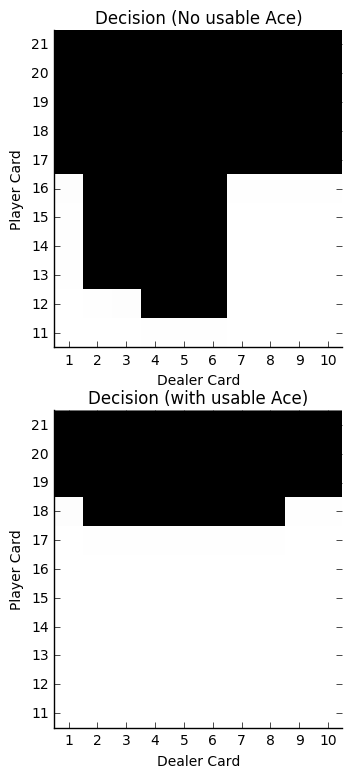

In [16]:
optimal_policy.visualize()

# Q: What's the house edge for this optimal policy ?

In [17]:
#Use MC to compute prob(i,j,k)
prob = np.zeros((21,10,2))
np.random.seed(4)
max_iter = int(1e5) #reduce max_iter to 1e6 generates correct result except for the case player=12, dealer=4, use_able=0 
for _ in range(max_iter):
    dealer_init_cards = np.random.choice(learner.game.cards,size=2,replace=True)
    player_init_cards = np.random.choice(learner.game.cards,size=2, replace=True)
    i,j,k = convert_cards_to_state(player_init_cards, dealer_init_cards[0])
    prob[i,j,k] = prob[i,j,k] + 1.0 
prob = prob/max_iter

In [18]:
prob.sum()

0.99999999999999989

In [19]:
#E[Reture]= sum_{i,j,k} Prob[i,j,k] * E[Reture|i,j,k], E[Return|i,j,k]= optimal_policy.v
print "House edge: ", np.sum(prob*optimal_policy.v)

House edge:  -0.0465476640519
